In [97]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from enum import Enum
import re
import random
import wandb
from tqdm import tqdm
import helper
import time
import scan_dataset
import models

In [2]:
# Replace test-project by experiment
wandb.init(project="test-project", entity="atnlp")

wandb: Currently logged in as: christian2903 (atnlp). Use `wandb login --relogin` to force relogin


In [3]:
# !git clone https://github.com/brendenlake/SCAN

In [4]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [5]:
input_lang = scan_dataset.Lang()
output_lang = scan_dataset.Lang()

train_dataset = scan_dataset.ScanDataset(
    split=scan_dataset.ScanSplit.SIMPLE_SPLIT,
    input_lang=input_lang,
    output_lang=output_lang,
    train=True
)

test_dataset = scan_dataset.ScanDataset(
    split=scan_dataset.ScanSplit.SIMPLE_SPLIT,
    input_lang=input_lang,
    output_lang=output_lang,
    train=False
)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

MAX_LENGTH = max(train_dataset.input_lang.max_length, train_dataset.output_lang.max_length)

In [106]:
teacher_forcing_ratio = .5

def train_iteration(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    """A single training iteration."""
    # Reset the gradients and loss
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0

    # Encode the input
    encoder_hidden, encoder_hidden_all = encoder(input_tensor)

    # Prepare the initial decoder input
    decoder_input = torch.tensor([[scan_dataset.SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    target_length = target_tensor.size(0)
    for di in range(target_length):
        # Decode next token
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_hidden_all)
            
        loss += criterion(decoder_output, target_tensor[di])

        # If teacher forcing is used, the next input is the target
        # Otherwise, the next input is the output with the highest probability
        if use_teacher_forcing:
            decoder_input = target_tensor[di]
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

        # If the decoder input is the EOS token, stop decoding
        if decoder_input.item() == scan_dataset.EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [123]:
def train(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=1e-2, verbose = False):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iteration in tqdm(range(1, n_iters + 1), total=n_iters, leave=False, desc="Training"):
        X, y = train_dataset[random.randrange(len(train_dataset))]
        input_tensor, target_tensor = train_dataset.convert_to_tensor(X, y)

        loss = train_iteration(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iteration % print_every == 0 and verbose:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            # wandb.log({"avg_loss": print_loss_avg})
            print('%d (%d%%): %.4f' % (iteration, iteration / n_iters * 100, print_loss_avg))

        if iteration % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    helper.show_plot(plot_losses)

    return encoder, decoder

In [126]:
def evaluate(dataset, encoder, decoder, max_length, verbose=False, batch_size=1, shuffle=False):
    
    n_correct = [] # number of correct predictions
    
    with torch.no_grad():
        for input_tensor, target_tensor in tqdm(dataset, total=len(dataset), leave=False, desc="Evaluating"):
            print(input_tensor, target_tensor)
            input_tensor, target_tensor = dataset.convert_to_tensor(input_tensor, target_tensor)
            
            pred = []

            encoder_hidden, encoder_hidden_all = encoder(input_tensor)

            decoder_input = torch.tensor([[scan_dataset.SOS_token]], device=device)

            decoder_hidden = encoder_hidden

            for di in range(max_length):
                decoder_output, decoder_hidden = decoder(
                        decoder_input, decoder_hidden, encoder_hidden_all)
                    
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                pred.append(decoder_input.item())

                if decoder_input.item() == scan_dataset.EOS_token:
                    break

            pred = np.array(pred)
            ground_truth = target_tensor.detach().cpu().numpy().squeeze()

            print("pred", pred)
            print("ground_truth", ground_truth)
            print()
            if len(pred) == len(ground_truth):
                n_correct.append(np.all(pred == ground_truth))
            else:
                n_correct.append(0)
    

    accuracy = np.mean(n_correct)
    if verbose:
        print("Accuracy", accuracy)

    return accuracy

In [127]:
evaluate(test_dataset, encoder, decoder, max_length=100, verbose=True)

Evaluating:   0%|          | 12/4182 [00:00<00:36, 114.82it/s]

 turn opposite right thrice and turn opposite left   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  4  8 13]

 run right twice after walk right twice   I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7  4  7  4 10  4  9]

 look around ri

Evaluating:   1%|          | 36/4182 [00:00<00:36, 112.88it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 12 15]

 walk thrice and turn left   I_WALK I_WALK I_WALK I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  7  7  7 13]

 turn opposite right thrice and run right   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10

Evaluating:   1%|▏         | 60/4182 [00:00<00:36, 112.64it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [3 4 4 7 4 4 7 4 4 7 8 8 9]

 jump thrice after turn around right twice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  4  4  4  5  5 14]

 jump opposite right and run around left twice   I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I

Evaluating:   2%|▏         | 83/4182 [00:00<00:39, 104.42it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  8 12  8 12  4  4 11]

 jump opposite right after run around right thrice   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_trut

Evaluating:   3%|▎         | 105/4182 [00:01<00:42, 94.86it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 12  4  4 12  8  8  8  8  8  8  8  8  8  8  8 13]

 jump around right thrice after jump around left twice   I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10

Evaluating:   3%|▎         | 128/4182 [00:01<00:39, 102.55it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  8 10  8 10  8 10  8  9]

 run right thrice after look   I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12  4 10  4 10  4  9]

 run opposite right thrice after run right   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10

Evaluating:   4%|▎         | 151/4182 [00:01<00:38, 106.04it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 12  4  4  4  4  4  6]

 turn around right twice after walk opposite left   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [3 8 8 7 4 4 4 4 4 4 4 6]

 jump opposite right thrice and look thrice   I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_

Evaluating:   4%|▍         | 163/4182 [00:01<00:36, 109.51it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7 12 15]

 run around right thrice after run   I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  

Evaluating:   4%|▍         | 188/4182 [00:01<00:35, 111.37it/s]

 look right thrice and turn opposite right thrice   I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 12  4 12  4 12  4  4  4  4  4  6]

 look and jump right   I_LOOK I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12  4 14]

 turn around right twice and look around right twice 

Evaluating:   5%|▌         | 212/4182 [00:01<00:37, 106.10it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  8  8  8 13]

 look right twice and run opposite right   I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 12  4 12  4  4  9]

 run around right and walk around right twice   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_WALK

Evaluating:   6%|▌         | 235/4182 [00:02<00:36, 107.67it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12 12 12  4  4  4  6]

 turn right after run left   I_TURN_LEFT I_RUN I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  6]

 look opposite left thrice after turn right thrice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10 

Evaluating:   6%|▌         | 258/4182 [00:02<00:35, 109.96it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  8  8 10  8  8 10 14]

 look left and walk left   I_TURN_LEFT I_LOOK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 11]

 look twice and jump around right thrice   I_LOOK I_LOOK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_

Evaluating:   7%|▋         | 282/4182 [00:02<00:34, 112.62it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4  9]

 turn around left thrice after look thrice   I_LOOK I_LOOK I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12 12 12  8  8  8  8  8  8  8  8  8  8  8 13]

 look around right

Evaluating:   7%|▋         | 306/4182 [00:02<00:34, 111.65it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  8 10  8  8  8  8  8  8  8  8  8  8  8 13]

 run after look opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 12  4  4 12  9]

 walk opposite right twice after run opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIG

Evaluating:   8%|▊         | 329/4182 [00:03<00:35, 108.00it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  7  8  7  8  7  8 11]

 jump around right twice and run opposite left twice   I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  5  4  5  4  5  4  5  4  5  4  5  4 

Evaluating:   8%|▊         | 340/4182 [00:03<00:39, 96.19it/s] 


 run opposite left thrice and run right thrice   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  8  8 10  8  8 10  4 10  4 10  4  9]

 jump left twice after walk left   I_TURN_LEFT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7 

Evaluating:   9%|▊         | 360/4182 [00:03<00:41, 91.61it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8
 12  8 11]

 look thrice after turn around right thrice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_LOOK I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  4  4  4  4  4  4  4 12 

Evaluating:   9%|▉         | 381/4182 [00:03<00:39, 97.08it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  8 12  8 12  8 12  8 15]

 turn opposite left and turn left thrice   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8 13]

 look opposite left and jump left twice   I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 1

Evaluating:  10%|▉         | 404/4182 [00:03<00:36, 103.83it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7  8 10  8  9]

 walk opposite left thrice after walk opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  7  4  4  7  8  8  7  8  8  7  8  8 11]

 turn around right thrice and jump   I_TURN_

Evaluating:  10%|█         | 428/4182 [00:04<00:34, 109.60it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  5  8  8  5  4 10  4 10  4 10  4  9]

 look thrice after jump right thrice   I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_LOOK I_LOOK I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  5  4  5  4  5 12 12 15]

 look right twice and run right twice   I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 1

Evaluating:  11%|█         | 452/4182 [00:04<00:33, 111.76it/s]



 run opposite right after look left twice   I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  4  4  9]

 walk around left after walk opposite right thrice   I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4

Evaluating:  11%|█         | 464/4182 [00:04<00:35, 103.45it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8  8  8  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4 11]

 look around left after run opposite left thrice   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  8  8 10  8  8 10  8 12  8 12  8 12  8 15]

 look

Evaluating:  12%|█▏        | 486/4182 [00:04<00:36, 100.32it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  5  4  4 14]

 run right after jump opposite right   I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [3 4 4 5 4 9]

 walk left and run around right thrice   I_TURN_LEFT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN 

Evaluating:  12%|█▏        | 508/4182 [00:04<00:36, 101.62it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8  8  8 14]

 jump opposite left twice and run around right thrice   I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  

Evaluating:  13%|█▎        | 530/4182 [00:05<00:37, 97.92it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 12  8  8 12 12 15]

 jump left after run opposite left   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  8 14]

 turn right twice after turn opposite left thrice   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10 

Evaluating:  13%|█▎        | 553/4182 [00:05<00:34, 104.35it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  7  4  4  7  4  4  7  4  4 14]

 walk left twice and look left thrice   I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8 12  8 12  8 15]

 run opposite right thrice after look around left thrice   I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_T

Evaluating:  14%|█▍        | 576/4182 [00:05<00:33, 108.11it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4  5  8 10  8 10  8 10  8
 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8  9]

 run right after turn around left   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [3 8 8 8 8 4 9]

 walk right thrice and walk left twice   I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_T

Evaluating:  14%|█▍        | 600/4182 [00:05<00:32, 110.08it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  5  8  5  8  5  8 14]

 walk left thrice after jump around left   I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  5  8  5  8  5  8  5  8  7  8  7  8 11]

 jump right twice after walk opposite left thrice   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TUR

Evaluating:  15%|█▍        | 624/4182 [00:05<00:31, 111.64it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  7  7  7  8  8  5  8  8 14]

 jump opposite right twice and jump thrice   I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP I_JUMP I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  5  4  4  5  5  5 14]

 walk around left twice and turn opposite right thrice   I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I

Evaluating:  15%|█▌        | 636/4182 [00:06<00:31, 112.13it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  5  4  5  4  5 11]

 look opposite left thrice and run twice   I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_RUN I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 12  8  8 12  8  8 12 10  9]

 walk after run around left twice   I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

Evaluating:  16%|█▌        | 659/4182 [00:06<00:35, 99.01it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  8  7  8  7  8 11]

 jump around right twice after walk opposite left   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  7  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4 14]

 lo

Evaluating:  16%|█▋        | 682/4182 [00:06<00:33, 103.49it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  4  8  8  8 13]

 jump opposite left after turn opposite right thrice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  4  8  8 14]

 run left and turn left thrice   I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 

Evaluating:  17%|█▋        | 705/4182 [00:06<00:32, 107.51it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8 15]

 look twice and look opposite right   I_LOOK I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12 12  4  4 15]

 jump around right after look around right   I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10 

Evaluating:  17%|█▋        | 727/4182 [00:06<00:33, 103.48it/s]


ground_truth [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4  7  4 11]

 look around right after walk opposite left twice   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  7  8  8  7  4 12  4 12  4 12  4 15]

 turn opposite right after walk thrice   I_WALK I_WALK I_WALK I_TURN_RIGHT I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10 

Evaluating:  18%|█▊        | 749/4182 [00:07<00:34, 100.12it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12 12  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8
 10  8  9]

 look right thrice after run around left   I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  8 10  4 12  4 12  4 15]

 walk thrice after walk around left   I_TUR

Evaluating:  18%|█▊        | 772/4182 [00:07<00:32, 105.18it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  5  4  4  5  4  4  5  7 11]

 turn opposite left twice after walk opposite left   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  7  8  8  8 13]

 look around left thrice and turn around left thrice   I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_T

Evaluating:  19%|█▉        | 795/4182 [00:07<00:31, 107.02it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4
  5  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8  9]

 run opposite left and jump opposite right thrice   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  4  4  5  4  4  5  4  4 14]

 

Evaluating:  20%|█▉        | 817/4182 [00:07<00:31, 106.57it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  7  7 11]

 run right thrice after turn around left   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8  4 10  4 10  4  9]

 turn opposite right thrice and look right twice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I

Evaluating:  20%|██        | 839/4182 [00:07<00:31, 105.44it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 15]

 run opposite right twice and jump opposite left   I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 10  4  4 10  8  8 14]

 jump right and turn around right twice   I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TU

Evaluating:  21%|██        | 862/4182 [00:08<00:30, 108.16it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  8 13]

 turn around left twice after walk opposite right   I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  7  8  8  8  8  8  8  8 13]

 walk left thrice after jump thrice   I_JUMP I_JUMP I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK


Evaluating:  21%|██        | 873/4182 [00:08<00:34, 96.26it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12  7  7 11]

 jump left twice after walk around left   I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7  8  7  8  5  8 14]

 look around left thrice after walk   I_WALK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_

Evaluating:  21%|██▏       | 894/4182 [00:08<00:34, 96.61it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  8  8 10  8  8 10 10 10  9]

 walk around left thrice after look around right twice   I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 

Evaluating:  22%|██▏       | 915/4182 [00:08<00:33, 98.98it/s]


ground_truth [ 3  4  7  4 12  4 12  4 12  4 12  4 12  4 12  4 12  4 15]

 look left twice and turn left thrice   I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  8  8 13]

 jump after jump around left   I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  5  8  5  8  5

Evaluating:  22%|██▏       | 938/4182 [00:08<00:31, 104.53it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  7  8  8  7  8  8  7 10 10  9]

 walk right thrice after turn left twice   I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  4  7  4  7  4 11]

 jump left thrice and run right twice   I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  

Evaluating:  23%|██▎       | 961/4182 [00:09<00:30, 106.31it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [3 8 7 8 7 8 7 8 7 8 7 8 7 8 7 8 7 8 9]

 jump and walk opposite left twice   I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  5  8  8  7  8  8 11]

 walk right twice after run right twice   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10

Evaluating:  24%|██▎       | 983/4182 [00:09<00:30, 106.17it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  5  8  5  8 10  8 10  8 10  8  9]

 look and run around right   I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12  4 10  4 10  4 10  4  9]

 jump around left twice and jump opposite right twice   I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I

Evaluating:  24%|██▍       | 1005/4182 [00:09<00:31, 100.39it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 10 10 10  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4 14]

 turn opposite right and walk left thrice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  8  7  8  7  8 11]

 walk twice after look thrice   I_LOOK I_LOOK I_LOOK I_WALK I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10 

Evaluating:  24%|██▍       | 1016/4182 [00:09<00:34, 91.14it/s] 


ground_truth [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  5 14]

 look left after run left   I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 15]

 jump around right and look around left   I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_t

Evaluating:  25%|██▍       | 1038/4182 [00:09<00:32, 97.37it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8  8  5  8  8 14]

 run around right thrice after run around left thrice   I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 

Evaluating:  25%|██▌       | 1061/4182 [00:10<00:30, 101.02it/s]

  I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7  8 10  8 10  8  9]

 look around left thrice after jump right thrice   I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  

Evaluating:  26%|██▌       | 1084/4182 [00:10<00:29, 105.10it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  4  4 12  4  4 12  4  4 15]

 walk twice and look left twice   I_WALK I_WALK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  7  7  8 12  8 15]

 turn opposite right thrice and look opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOO

Evaluating:  26%|██▋       | 1108/4182 [00:10<00:28, 108.87it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7 12 12 15]

 walk around left and jump around right   I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7  8  7  4  5  4  5  4  5  4 14]

 jump opposite right and turn left thrice   I_TURN_RIGHT I_TURN_RIGHT I_

Evaluating:  27%|██▋       | 1130/4182 [00:10<00:31, 98.30it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  8 12  8 12  8 15]

 walk left thrice and walk right   I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7  4 11]

 turn around left twice after run opposite right   I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT 

Evaluating:  28%|██▊       | 1153/4182 [00:11<00:29, 103.62it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4  4  4  4  4  4  4  4  4  4  4  6]

 look around left and run thrice   I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_RUN I_RUN I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  8 12  8 12 10 10  9]

 jump opposite left after walk opposite left thrice   I_TURN_LEFT I_

Evaluating:  28%|██▊       | 1164/4182 [00:11<00:28, 104.92it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8  8 13]

 run around right thrice and turn right twice   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  4 10 

Evaluating:  28%|██▊       | 1186/4182 [00:11<00:28, 105.47it/s]

 walk twice after turn around left   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8  7 11]

 run right twice   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4  9]

 turn right thrice and run twice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4

Evaluating:  29%|██▉       | 1209/4182 [00:11<00:28, 103.35it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  8  8 11]

 walk opposite left and walk around right thrice   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  

Evaluating:  29%|██▉       | 1232/4182 [00:11<00:31, 94.39it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  4 11]

 look opposite left thrice after turn opposite right thrice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  4  8  8 12  8  8 12  8  8 15]

 look right and walk right   I_TURN_RIGHT I_LOOK I_T

Evaluating:  30%|██▉       | 1253/4182 [00:12<00:31, 93.62it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [3 8 5 4 6]

 look and walk right   I_LOOK I_TURN_RIGHT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12  4 11]

 run around right twice after walk opposite right   I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4

Evaluating:  30%|███       | 1263/4182 [00:12<00:31, 92.35it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4  4  4  4  4  4  4  4  8  8  8 13]

 jump around left after jump thrice   I_JUMP I_JUMP I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  5  5  5  8  5  8  5  8  5  8 14]

 look opposite left and run right twice   I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4

Evaluating:  31%|███       | 1283/4182 [00:12<00:35, 82.14it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 12  4 12  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4
  7  4  7  4 11]

 jump opposite left thrice after run around left   I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  8 10  8  8  5  8  8  

Evaluating:  31%|███       | 1303/4182 [00:12<00:32, 89.38it/s]

 [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  7  4  4  7  4  4  7  8  8 11]

 jump twice after look opposite left   I_TURN_LEFT I_TURN_LEFT I_LOOK I_JUMP I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 12  5 14]

 turn left twice after jump around left   I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4

Evaluating:  32%|███▏      | 1324/4182 [00:12<00:30, 95.02it/s]

 turn around right after run left thrice   I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  4  4  4  6]

 look opposite right and jump opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 12 

Evaluating:  32%|███▏      | 1344/4182 [00:13<00:30, 93.19it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4 11]

 look opposite right thrice after jump around right thrice   I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10 

Evaluating:  33%|███▎      | 1366/4182 [00:13<00:28, 97.62it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  4  4  4  4  4  4  4  4  4  4  4  6]

 look thrice after turn left thrice   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_LOOK I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8 12 12 15]

 jump opposite right thrice after run right twice   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RI

Evaluating:  33%|███▎      | 1376/4182 [00:13<00:28, 97.87it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8  8  7  8  8  7  8
  8 11]

 turn opposite right twice and look around right   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  4 12  4 12  4 12  4 15]

 jump left thrice after run right twice   I_

Evaluating:  33%|███▎      | 1396/4182 [00:13<00:30, 90.27it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7  8  7  8  7  8  7  8  7  8  7  8  7  8  7  8  7  8
  7  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
  9]

 turn opposite left after walk opposite left thrice   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  7  8  8  7  8  8 

Evaluating:  34%|███▍      | 1417/4182 [00:13<00:29, 93.90it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 12  4 12  4 12  4 12  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8
  9]

 walk left twice and walk around left   I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  7  8  7  8  7  8  7  8  7  8 11]

 turn opposite right and turn around right twice   I_TURN_RIGHT I_TURN_RIGHT

Evaluating:  34%|███▍      | 1437/4182 [00:14<00:29, 91.71it/s]

 [ 3  4 12  4 12  4 12  4 12  4 12  4 12  4 12  4 12  4  6]

 walk after walk around right   I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7  4  7  4  7  4  7 11]

 run opposite left twice and walk left thrice   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4

Evaluating:  35%|███▍      | 1458/4182 [00:14<00:28, 95.59it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 10  4  4  4  6]

 walk opposite right after look right   I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 12  4  4 11]

 run twice and walk around right twice   I_RUN I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WA

Evaluating:  35%|███▌      | 1480/4182 [00:14<00:27, 99.95it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  5  7  7 11]

 walk around left after run opposite left twice   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  8  8 10  8  7  8  7  8  7  8 11]

 look around left after walk opposite left twice   I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT

Evaluating:  36%|███▌      | 1502/4182 [00:14<00:27, 98.05it/s] 

 run left twice and walk around right   I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  4  7  4  7  4  7  4 11]

 walk around left after jump right   I_TURN_RIGHT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  5  8  7  8 

Evaluating:  36%|███▋      | 1522/4182 [00:14<00:27, 95.38it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  4  4 12  4  4 15]

 jump around left and look opposite right   I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  5  8  5  8  5  8  5  4  4 15]

 jump opposite right twice after run opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_

Evaluating:  37%|███▋      | 1532/4182 [00:15<00:27, 95.25it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8 10 10  9]

 run opposite left thrice and look right   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  8  8 10  8  8 10  4 15]

 walk after walk opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_WALK

pred [ 3  4 10  4 

Evaluating:  37%|███▋      | 1553/4182 [00:15<00:27, 95.77it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  5  4  5  4  5  4  5  4  5  4  5  4  5  4  5  8  8  7  8  8 11]

 jump twice and walk around left twice   I_JUMP I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  5  5  8  7  8  7  8  7  8  7  8  7  8  7  8  7  8 11]

 jump around

Evaluating:  38%|███▊      | 1573/4182 [00:15<00:28, 91.24it/s]

 walk around right thrice and run around right thrice   I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4
  7  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
  9]


Evaluating:  38%|███▊      | 1594/4182 [00:15<00:26, 96.90it/s]

 [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 12  8  8 12  8  8 12  4  5  4  5  4 14]

 run opposite right thrice after turn around left thrice   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  

Evaluating:  39%|███▊      | 1617/4182 [00:15<00:24, 103.26it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8
 12  8  8 10  8  8 10  8  8  9]

 turn left twice after turn around right thrice   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4

Evaluating:  39%|███▉      | 1639/4182 [00:16<00:24, 104.57it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  5 14]

 jump around left twice after walk right thrice   I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7  4  7  4  7  8  5  

Evaluating:  40%|███▉      | 1661/4182 [00:16<00:25, 100.27it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4 15]

 run right and jump   I_TURN_RIGHT I_RUN I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10 14]

 jump opposite left thrice after look right twice   I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4

Evaluating:  40%|████      | 1683/4182 [00:16<00:25, 99.41it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8
 10  8  8  9]

 jump around left thrice after jump twice   I_JUMP I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10 

Evaluating:  41%|████      | 1706/4182 [00:16<00:23, 103.58it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 10  9]

 walk right and look   I_TURN_RIGHT I_WALK I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7 15]

 jump around left twice after jump opposite left twice   I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JU

Evaluating:  41%|████      | 1717/4182 [00:16<00:24, 102.47it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 12  4 12  4 12  4 12  4 12  4 12  4 12  4 12  4  4  7  4  4  7  4
  4 11]

 look after walk right   I_TURN_RIGHT I_WALK I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7 15]

 walk around right thrice and jump around right   I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT

Evaluating:  42%|████▏     | 1740/4182 [00:17<00:24, 100.46it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 12 15]

 look left twice after turn around right   I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  4  4  8 12  8 15]

 look opposite left thrice after run right twice   I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_

Evaluating:  42%|████▏     | 1761/4182 [00:17<00:25, 96.29it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  5  5  5  8 11]

 jump around left after run opposite right twice   I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 10  4  4 10  8  5  8  5  8  5  8 14]

 turn left and turn around left   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LE

Evaluating:  43%|████▎     | 1782/4182 [00:17<00:25, 95.99it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  5  5  8 12  8 15]

 turn opposite left thrice and walk around left   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8  8  8  8  7  8  7  8  7  8 11]

 turn around left twice after jump right   I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN

Evaluating:  43%|████▎     | 1804/4182 [00:17<00:23, 101.09it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4  5  4  4  5  4  4  5  4  5  4  5  4 14]

 run opposite right thrice and turn right twice   I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  4 10  4  4 10  4  4 10  4  6]

 look around left twice after walk opposite left twice   I_TURN_LEFT I_TURN_LEFT I_WALK I

Evaluating:  44%|████▎     | 1826/4182 [00:18<00:22, 105.08it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  8  5  8  5  8  5  8
 14]

 jump opposite right twice after run opposite left   I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8 10  4  4  5  4  4 14]

 walk opposite right after turn left twice   I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_R

Evaluating:  44%|████▍     | 1848/4182 [00:18<00:23, 101.37it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7  4  7  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8 12  8
 12  8 12  8 15]

 look twice and run around right twice   I_LOOK I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3 12 12  4 10  4 10  4 10  4 10  4 10  4 10  4 10  

Evaluating:  44%|████▍     | 1859/4182 [00:18<00:23, 99.75it/s] 

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  8 10  4  4 14]

 walk around right twice and run right twice   I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4  7  4 10  4  9]

 

Evaluating:  45%|████▌     | 1882/4182 [00:18<00:23, 98.55it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  7  7  7  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8  9]

 run left twice and run around left twice   I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8 10  8  9]

Evaluating:  46%|████▌     | 1905/4182 [00:18<00:21, 104.33it/s]

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  8 13]

 jump twice after turn left thrice   I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_JUMP

pred [ 3  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4 10  4
 10  4 10  4]
ground_truth [ 3  8  8  8  5 14]

 look opposite left and run around left twice   I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN

Evaluating:  46%|████▌     | 1927/4182 [00:19<00:21, 105.50it/s]

Accuracy 0.0


0.0

<Figure size 432x288 with 0 Axes>

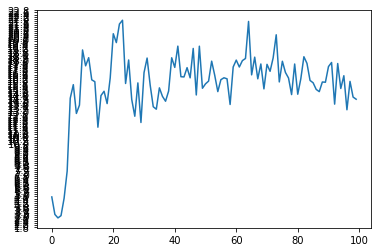

In [122]:
hidden_size = 256

config = {
    'HIDDEN_SIZE': 256, # 25, 50, 100, 200, or 400
    'RNN_TYPE': 'RNN', # RNN, GRU or LSTM
    'N_LAYERS': 2, # 1 or 2
    'DROPOUT': 0, # 0, 0.1 or 0.5
}

wandb.config = config

encoder = models.EncoderRNN(train_dataset.input_lang.n_words, config['HIDDEN_SIZE'], device, config['N_LAYERS'], config['RNN_TYPE'], config['DROPOUT']).to(device)
decoder = models.DecoderRNN(train_dataset.output_lang.n_words, config['HIDDEN_SIZE'], config['N_LAYERS'], config['RNN_TYPE'], config['DROPOUT']).to(device)
# decoder1 = AttnDecoderRNN(train_dataset.output_lang.n_words, config['HIDDEN_SIZE'], config['N_LAYERS'], config['RNN_TYPE'], config['RNN_TYPE']).to(device)

encoder, decoder = train(encoder, decoder, 10000, print_every=100, learning_rate=0.001)

evaluate(test_dataset, encoder, decoder, max_length=100, verbose=True)



### Experiment 1

The top-performing architecture was a LSTM with no attention, 2
layers of 200 hidden units, and no dropout. The best-overall
network achieved 99.7% correct.

SCAN tasks were randomly split into a training set (80%) and a test set (20%).

### Experiment 2

The best result (20.8% on average, again over 5 runs) is achieved
by a GRU with attention, one 50-dimensional hidden layer,
and dropout 0.5

In [13]:
wandb.init(project="experiment-2", entity="atnlp")

In [14]:
input_lang = Lang()
output_lang = Lang()

NameError: name 'Lang' is not defined

In [ ]:
train_dataset = ScanDataset(
    split=ScanSplit.LENGTH_SPLIT,
    input_lang=input_lang,
    output_lang=output_lang,
    train=True
)

test_dataset = ScanDataset(
    split=ScanSplit.LENGTH_SPLIT,
    input_lang=input_lang,
    output_lang=output_lang,
    train=False
)

assert (len(train_dataset) == 16990)
assert (len(test_dataset) == 3920)

In [ ]:
experiment_2_config = dict(HIDDEN_SIZE=50, N_LAYERS=1, DROPOUT=.5, RNN_TYPE='GRU')
overall_best_config = dict(HIDDEN_SIZE=200, N_LAYERS=2, DROPOUT=.5, RNN_TYPE='LSTM')

config = experiment_2_config

In [ ]:
encoder_exp_2 = EncoderRNN(input_lang.n_words, config=config).to(device)
decoder_exp_2 = DecoderRNN(output_lang.n_words, config=config).to(device)
attn_decoder_exp_2 = AttnDecoderRNN(output_lang.n_words, config=config).to(device)

/shared-libs/python3.9/py/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
train_iterations(encoder_exp_2, attn_decoder_exp_2, 10000, print_every=100)

0m 4s (- 7m 30s) (100 1%) 2.1491
0m 9s (- 7m 53s) (200 2%) 1.8391
0m 14s (- 7m 40s) (300 3%) 1.8041
0m 19s (- 7m 37s) (400 4%) 1.7459
0m 24s (- 7m 37s) (500 5%) 1.7441
0m 28s (- 7m 27s) (600 6%) 1.7132
0m 33s (- 7m 20s) (700 7%) 1.7615
0m 38s (- 7m 19s) (800 8%) 1.6810
0m 43s (- 7m 18s) (900 9%) 1.6580
0m 48s (- 7m 13s) (1000 10%) 1.6702
0m 52s (- 7m 6s) (1100 11%) 1.6138
0m 57s (- 7m 0s) (1200 12%) 1.4693
1m 2s (- 6m 56s) (1300 13%) 1.5826
1m 7s (- 6m 53s) (1400 14%) 1.5038
1m 12s (- 6m 52s) (1500 15%) 1.5233
1m 18s (- 6m 49s) (1600 16%) 1.3632
1m 23s (- 6m 46s) (1700 17%) 1.4715
1m 28s (- 6m 43s) (1800 18%) 1.4320
1m 34s (- 6m 40s) (1900 19%) 1.4505
1m 39s (- 6m 36s) (2000 20%) 1.4093
1m 44s (- 6m 32s) (2100 21%) 1.3209
1m 49s (- 6m 26s) (2200 22%) 1.3297
1m 54s (- 6m 21s) (2300 23%) 1.3695
1m 58s (- 6m 15s) (2400 24%) 1.3888
2m 3s (- 6m 10s) (2500 25%) 1.2416
2m 8s (- 6m 7s) (2600 26%) 1.3154
2m 14s (- 6m 3s) (2700 27%) 1.3073
2m 20s (- 6m 0s) (2800 28%) 1.2706
2m 25s (- 5m 55s) (29

In [ ]:
evaluate(test_dataset, encoder_exp_2, attn_decoder_exp_2)

0.0

### Experiment 3

The best performance is achieved by
a GRU network with attention, one layer with 100 hidden
units, and dropout of 0.1 (90.3% accuracy). 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec00d141-8917-4313-a10a-78395d2ec852' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>